In [1]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, Markdown, HTML

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 11

# Suppress warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Cell 2: Load Insurance Data for Outlier Detection
print("="*80)
print("📂 LOADING INSURANCE DATA FOR OUTLIER DETECTION")
print("="*80)

from pathlib import Path
import pandas as pd
import numpy as np

# CORRECT: Use cleaned_data.txt (not .csv)
data_path = Path("../../data/01_interim/cleaned_data.txt")

print(f"📁 Data path: {data_path.absolute()}")

if not data_path.exists():
    print(f"❌ ERROR: File not found!")
    print(f"📋 Current directory: {Path.cwd()}")
    
    # Show what's available
    print(f"\n🔍 Checking data directory...")
    data_dir = Path("../../data/01_interim")
    if data_dir.exists():
        files = list(data_dir.glob("*"))
        if files:
            print(f"Files in {data_dir}:")
            for f in files:
                size_mb = f.stat().st_size / (1024**2) if f.is_file() else 0
                print(f"  📄 {f.name} ({size_mb:.1f} MB)")
        else:
            print("  (empty directory)")
    raise FileNotFoundError(f"File not found: {data_path}")

# Get file info
file_size_mb = data_path.stat().st_size / (1024**2)
print(f"✅ FOUND: cleaned_data.txt ({file_size_mb:.1f} MB)")

# Detect delimiter first
print(f"\n🔍 Detecting file format...")
with open(data_path, 'r', encoding='utf-8') as f:
    first_line = f.readline().strip()

# Simple delimiter detection
delimiters = {
    ',': first_line.count(','),
    '|': first_line.count('|'),
    '\t': first_line.count('\t'),
    ';': first_line.count(';')
}

delimiter = max(delimiters, key=delimiters.get)
delimiter_name = 'Tab' if delimiter == '\t' else f"'{delimiter}'"
print(f"📊 Detected delimiter: {delimiter_name}")

# LOAD FULL DATASET (not just sample)
print("\n📥 Loading FULL DATASET (this may take a moment)...")

try:
    # Load ALL data - remove nrows parameter
    df = pd.read_csv(
        data_path,
        delimiter=delimiter,
        low_memory=False,
        encoding='utf-8',
        on_bad_lines='warn'  # Warn about bad lines but continue loading
    )
    
    print(f"✅ SUCCESS: Loaded FULL dataset - {len(df):,} rows × {df.shape[1]} columns")
    print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
except Exception as e:
    print(f"❌ Error loading with '{delimiter}': {e}")
    print("\n🔄 Trying alternative loading method...")
    
    # Try auto-detection
    try:
        df = pd.read_csv(
            data_path,
            sep=None,  # Auto-detect
            engine='python',
            low_memory=False,
            on_bad_lines='skip'
        )
        print(f"✅ Loaded FULL dataset with auto-detection")
    except Exception as e2:
        print(f"❌ Auto-detection failed: {e2}")
        
        # Try comma as fallback
        try:
            df = pd.read_csv(
                data_path,
                delimiter=',',
                low_memory=False,
                encoding='utf-8',
                engine='python',
                on_bad_lines='skip'
            )
            print(f"✅ Loaded FULL dataset with comma delimiter")
        except Exception as e3:
            print(f"❌ All methods failed: {e3}")
            raise ValueError(f"Cannot load {data_path.name}. Check file format.")

# Display FULL dataset information
print("\n" + "="*80)
print("📊 FULL DATASET INFORMATION")
print("="*80)

print(f"\n• Total rows: {df.shape[0]:,}")
print(f"• Total columns: {df.shape[1]}")
print(f"• Memory: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"• Total cells: {df.shape[0] * df.shape[1]:,}")

print(f"\n📈 Data Types Distribution:")
dtype_counts = df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"  • {str(dtype):<15}: {count} columns")

print(f"\n⚠️ Missing Values:")
missing_total = df.isnull().sum().sum()
missing_pct = missing_total / (df.shape[0] * df.shape[1]) * 100
print(f"  • Total missing: {missing_total:,} ({missing_pct:.1f}%)")
print(f"  • Columns with missing: {(df.isnull().sum() > 0).sum()}")

if (df.isnull().sum() > 0).sum() > 0:
    print(f"  • Top 5 columns with most missing:")
    missing_by_col = df.isnull().sum().sort_values(ascending=False).head(5)
    for col, count in missing_by_col.items():
        pct = (count / len(df)) * 100
        print(f"    - {col}: {count:,} ({pct:.1f}%)")

print(f"\n🔍 First 10 columns:")
for i, col in enumerate(df.columns[:10], 1):
    dtype = str(df[col].dtype)
    unique = df[col].nunique()
    print(f"  {i:2d}. {col:25} [{dtype:10}] Unique: {unique:,}")

print(f"\n📋 First 2 rows of REAL DATA:")
print(df.head(2).to_string(max_cols=10, max_rows=2))

print("\n" + "="*80)
print("✅ DATA LOADING COMPLETE - READY FOR OUTLIER DETECTION")
print("="*80)

# Identify numeric columns for outlier analysis
numeric_cols = []
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() > 10:
        numeric_cols.append(col)

print(f"\n🔢 {len(numeric_cols)} numeric columns identified for outlier detection:")
for i, col in enumerate(numeric_cols[:10], 1):
    print(f"  {i:2d}. {col}")



📂 LOADING INSURANCE DATA FOR OUTLIER DETECTION
📁 Data path: d:\10 acadamy\insurance anlysis\Insurance_Risk_Analytics_Predictive_modeling\notebooks\task1_eda\..\..\data\01_interim\cleaned_data.txt
✅ FOUND: cleaned_data.txt (538.5 MB)

🔍 Detecting file format...
📊 Detected delimiter: '|'

📥 Loading FULL DATASET (this may take a moment)...
✅ SUCCESS: Loaded FULL dataset - 1,000,098 rows × 52 columns
💾 Memory usage: 2532.4 MB

📊 FULL DATASET INFORMATION

• Total rows: 1,000,098
• Total columns: 52
• Memory: 2532.4 MB
• Total cells: 52,005,096

📈 Data Types Distribution:
  • object         : 37 columns
  • float64        : 11 columns
  • int64          : 3 columns
  • bool           : 1 columns

⚠️ Missing Values:
  • Total missing: 1,000,650 (1.9%)
  • Columns with missing: 2
  • Top 5 columns with most missing:
    - numberofvehiclesinfleet: 1,000,098 (100.0%)
    - vehicleintrodate: 552 (0.1%)
    - underwrittencoverid: 0 (0.0%)
    - policyid: 0 (0.0%)
    - citizenship: 0 (0.0%)

🔍 Fir

In [3]:
# Cell 3: Identify Key Numerical Variables for Outlier Detection
print("="*80)
print("🔍 IDENTIFYING KEY NUMERICAL VARIABLES")
print("="*80)

# Select numerical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"📊 Found {len(numeric_cols)} numerical variables:")

# Display numerical columns with basic statistics
numeric_stats = []
for col in numeric_cols:
    non_null = df[col].notnull().sum()
    if non_null > 0:
        mean_val = df[col].mean()
        std_val = df[col].std()
        min_val = df[col].min()
        max_val = df[col].max()
        
        numeric_stats.append({
            'Variable': col,
            'Non-Null': non_null,
            'Mean': mean_val,
            'Std': std_val,
            'Min': min_val,
            'Max': max_val,
            'Range': max_val - min_val
        })

# Create summary DataFrame
numeric_df = pd.DataFrame(numeric_stats)

# Display top variables
print(f"\n📈 Top 15 Numerical Variables by Range (Potential Outlier Impact):")
top_vars = numeric_df.nlargest(15, 'Range')
for i, (_, row) in enumerate(top_vars.iterrows(), 1):
    print(f"   {i:2d}. {row['Variable']:25} Range: {row['Range']:,.2f}, Std: {row['Std']:,.2f}")

# Select key insurance metrics for outlier detection
insurance_metrics = ['TotalPremium', 'TotalClaims', 'SumInsured', 'RiskScore', 
                     'VehicleAge', 'DriverAge', 'NoClaimsDiscount', 'ClaimAmount',
                     'CalculatedPremiumPerTerm', 'ExcessAmount']

# Find which metrics exist in the data
available_metrics = [col for col in insurance_metrics if col in df.columns]

print(f"\n🎯 Key Insurance Metrics Available ({len(available_metrics)}):")
for i, metric in enumerate(available_metrics, 1):
    print(f"   {i:2d}. {metric}")

# If no specific metrics found, use top numerical variables
if not available_metrics and len(numeric_cols) > 0:
    available_metrics = numeric_cols[:5]  # Use first 5 numerical columns
    print(f"\n⚠️ Using first 5 numerical variables for analysis:")
    for i, metric in enumerate(available_metrics, 1):
        print(f"   {i:2d}. {metric}")

# Create analysis DataFrame
analysis_df = df[available_metrics].copy()

print(f"\n📋 Analysis DataFrame Shape: {analysis_df.shape}")
print(f"📊 Columns for outlier detection: {list(analysis_df.columns)}")

🔍 IDENTIFYING KEY NUMERICAL VARIABLES
📊 Found 14 numerical variables:

📈 Top 15 Numerical Variables by Range (Potential Outlier Impact):
    1. mmcode                    Range: 61,024,150.00, Std: 13,600,594.86
    2. customvalueestimate       Range: 26,530,000.00, Std: 265,052.09
    3. suminsured                Range: 12,636,199.99, Std: 1,508,331.84
    4. totalclaims               Range: 405,094.52, Std: 2,384.07
    5. underwrittencoverid       Range: 301,174.00, Std: 63,293.71
    6. calculatedpremiumperterm  Range: 74,422.17, Std: 399.70
    7. totalpremium              Range: 66,065.18, Std: 230.28
    8. policyid                  Range: 23,232.00, Std: 5,290.04
    9. cubiccapacity             Range: 12,880.00, Std: 442.71
   10. postalcode                Range: 9,869.00, Std: 2,649.85
   11. kilowatts                 Range: 309.00, Std: 19.39
   12. cylinders                 Range: 10.00, Std: 0.29
   13. numberofdoors             Range: 6.00, Std: 0.47

🎯 Key Insurance Metri

📊 UNIVARIATE OUTLIER DETECTION - STATISTICAL METHODS

🔍 Performing univariate outlier detection...

📊 Identifying numerical columns for outlier detection...

✅ Found 11 numeric columns for analysis

📈 Analyzing these columns:
   1. underwrittencoverid
   2. policyid
   3. postalcode
   4. mmcode
   5. cubiccapacity


🔍 Analyzing: underwrittencoverid
   • Method: IQR
   • Threshold: 3
   • Total observations: 1,000,098
   • Outliers detected: 0 (0.00%)


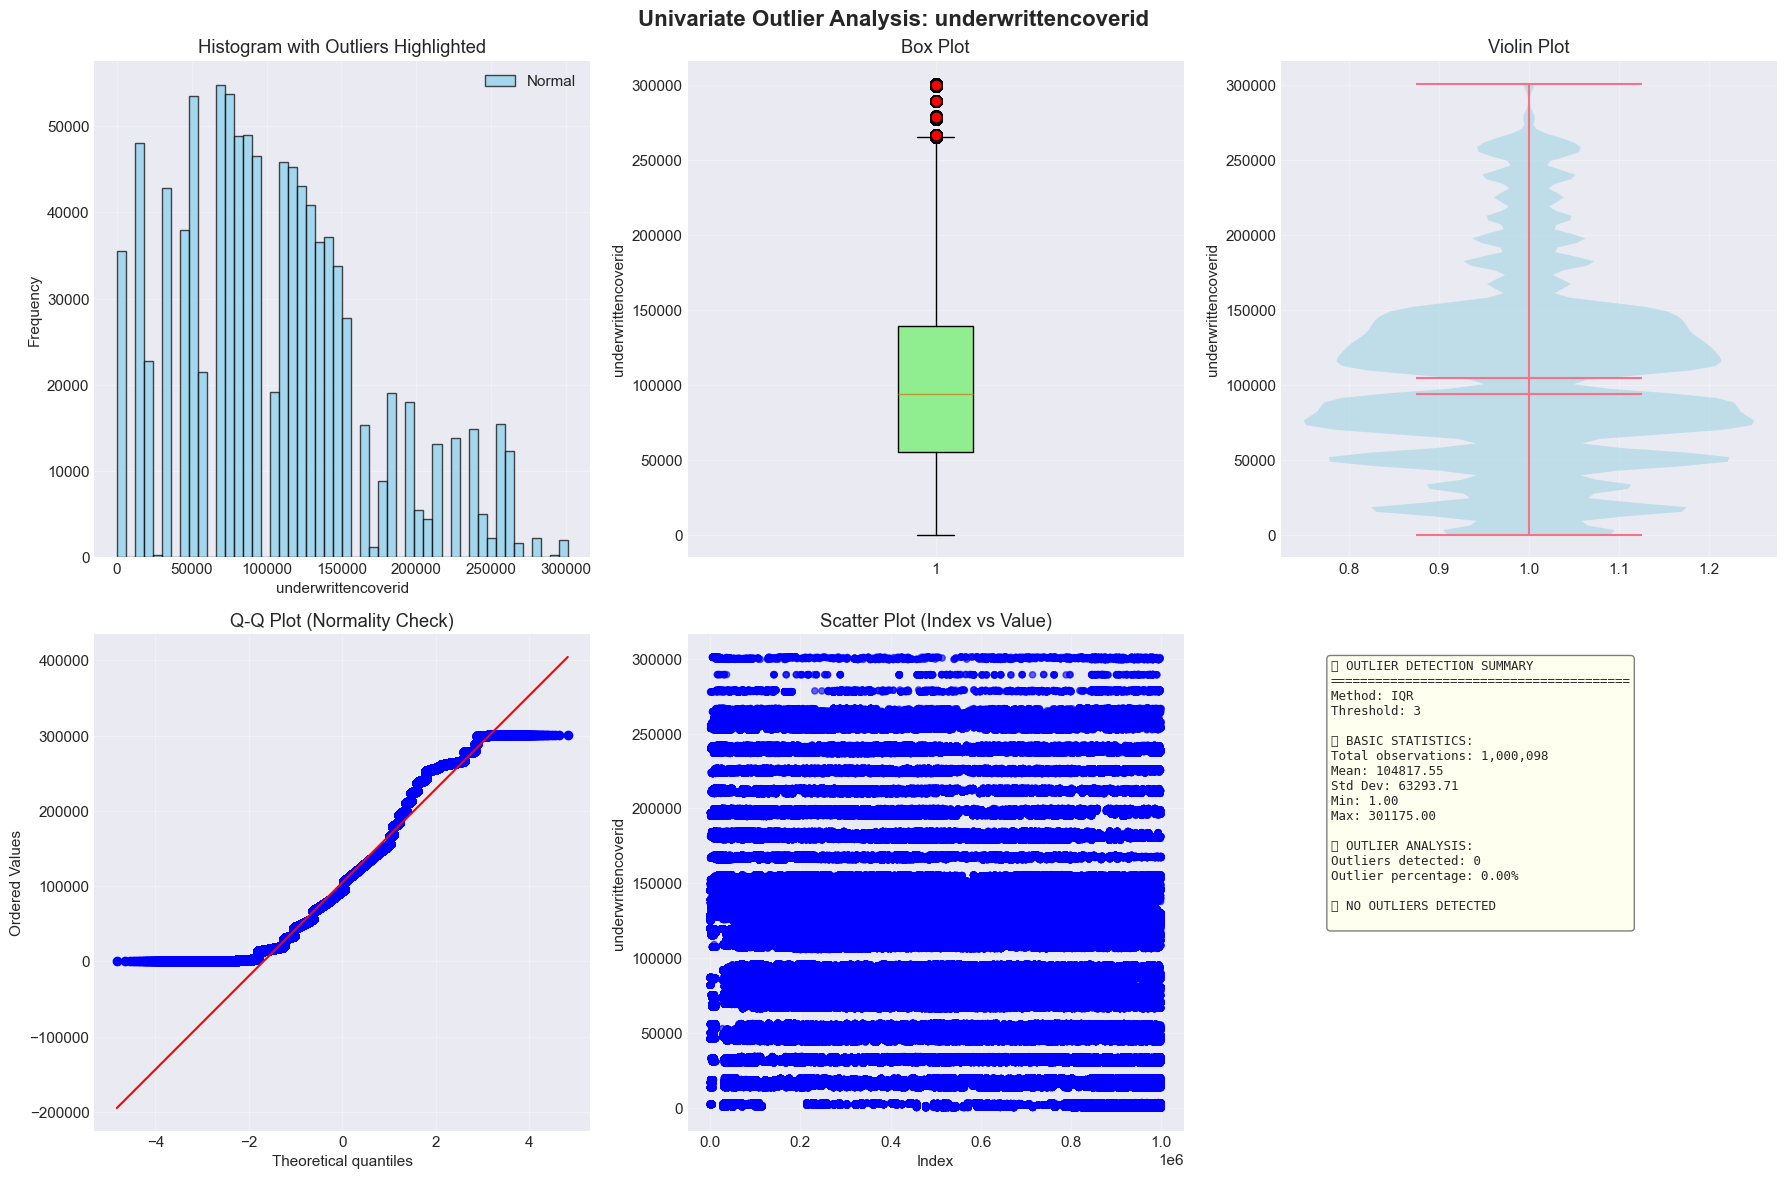



🔍 Analyzing: policyid
   • Method: IQR
   • Threshold: 3
   • Total observations: 1,000,098
   • Outliers detected: 0 (0.00%)


In [ ]:
# Cell 4: Univariate Outlier Detection - Statistical Methods
print("="*80)
print("📊 UNIVARIATE OUTLIER DETECTION - STATISTICAL METHODS")
print("="*80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

def detect_univariate_outliers(data, column, method='iqr', threshold=3):
    """
    Detect outliers using various univariate methods
    """
    print(f"\n🔍 Analyzing: {column}")
    print(f"   • Method: {method.upper()}")
    print(f"   • Threshold: {threshold}")
    
    # Clean data
    clean_data = data[column].dropna()
    n_total = len(clean_data)
    
    if n_total < 10:
        print("   ⚠️ Insufficient data for outlier detection")
        return None
    
    outliers_mask = None
    bounds = {}
    
    # Method 1: IQR (Interquartile Range)
    if method.lower() == 'iqr':
        Q1 = clean_data.quantile(0.25)
        Q3 = clean_data.quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        outliers_mask = (clean_data < lower_bound) | (clean_data > upper_bound)
        bounds = {'lower': lower_bound, 'upper': upper_bound, 'IQR': IQR}
    
    # Method 2: Z-Score
    elif method.lower() == 'zscore':
        z_scores = np.abs((clean_data - clean_data.mean()) / clean_data.std())
        outliers_mask = z_scores > threshold
        bounds = {'threshold': threshold}
    
    # Method 3: Modified Z-Score (robust to outliers)
    elif method.lower() == 'modified_zscore':
        median = clean_data.median()
        mad = np.median(np.abs(clean_data - median))
        
        if mad > 0:  # Avoid division by zero
            modified_z_scores = 0.6745 * (clean_data - median) / mad
            outliers_mask = np.abs(modified_z_scores) > threshold
            bounds = {'median': median, 'MAD': mad, 'threshold': threshold}
        else:
            print("   ⚠️ MAD is zero, cannot compute modified Z-score")
            return None
    
    # Method 4: Percentile-based
    elif method.lower() == 'percentile':
        lower_bound = clean_data.quantile(threshold/100)
        upper_bound = clean_data.quantile(1 - threshold/100)
        outliers_mask = (clean_data < lower_bound) | (clean_data > upper_bound)
        bounds = {'lower': lower_bound, 'upper': upper_bound}
    
    if outliers_mask is not None:
        n_outliers = outliers_mask.sum()
        pct_outliers = n_outliers / n_total * 100
        
        print(f"   • Total observations: {n_total:,}")
        print(f"   • Outliers detected: {n_outliers:,} ({pct_outliers:.2f}%)")
        
        # Get outlier values
        outlier_values = []
        if n_outliers > 0:
            outlier_values = clean_data[outliers_mask].tolist()
            print(f"   • Min outlier: {min(outlier_values):.2f}")
            print(f"   • Max outlier: {max(outlier_values):.2f}")
            print(f"   • Mean of outliers: {np.mean(outlier_values):.2f}")
        
        # Get outlier indices (original indices from clean_data)
        outlier_indices = []
        if n_outliers > 0:
            outlier_indices = clean_data.index[outliers_mask].tolist()
        
        return {
            'column': column,
            'method': method,
            'threshold': threshold,
            'n_total': n_total,
            'n_outliers': n_outliers,
            'pct_outliers': pct_outliers,
            'outlier_indices': outlier_indices,  # Added this
            'outlier_values': outlier_values,    # Added this
            'bounds': bounds,
            'basic_stats': {
                'mean': float(clean_data.mean()),
                'std': float(clean_data.std()),
                'min': float(clean_data.min()),
                'max': float(clean_data.max()),
                'median': float(clean_data.median()),
                'q1': float(clean_data.quantile(0.25)),
                'q3': float(clean_data.quantile(0.75))
            }
        }
    
    return None

def visualize_univariate_outliers(data, column, detection_results):
    """
    Visualize univariate outliers with multiple plots
    """
    if detection_results is None:
        print(f"❌ No detection results for {column}")
        return None
    
    # Get clean data
    clean_data = data[column].dropna()
    
    # Create outlier mask from detection results
    outliers_mask = pd.Series(False, index=clean_data.index)
    if detection_results['n_outliers'] > 0 and 'outlier_indices' in detection_results:
        outlier_indices = detection_results['outlier_indices']
        # Ensure indices exist in clean_data
        valid_indices = [idx for idx in outlier_indices if idx in clean_data.index]
        outliers_mask.loc[valid_indices] = True
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Univariate Outlier Analysis: {column}', fontsize=16, fontweight='bold')
    
    # 1. Histogram with outlier highlighting
    axes[0, 0].hist(clean_data[~outliers_mask], bins=50, alpha=0.7, 
                   color='skyblue', edgecolor='black', label='Normal')
    if outliers_mask.any():
        axes[0, 0].hist(clean_data[outliers_mask], bins=50, alpha=0.7,
                       color='red', edgecolor='black', label='Outliers')
    axes[0, 0].set_title(f'Histogram with Outliers Highlighted')
    axes[0, 0].set_xlabel(column)
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Box Plot
    bp = axes[0, 1].boxplot(clean_data, vert=True, patch_artist=True, 
                           showfliers=True, flierprops=dict(marker='o', markersize=8, markerfacecolor='red'))
    bp['boxes'][0].set_facecolor('lightgreen')
    axes[0, 1].set_title('Box Plot')
    axes[0, 1].set_ylabel(column)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Violin Plot
    parts = axes[0, 2].violinplot(clean_data, showmeans=True, showmedians=True)
    parts['bodies'][0].set_facecolor('lightblue')
    parts['bodies'][0].set_alpha(0.7)
    axes[0, 2].set_title('Violin Plot')
    axes[0, 2].set_ylabel(column)
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Q-Q Plot
    stats.probplot(clean_data, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot (Normality Check)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Scatter Plot (Index vs Value)
    colors = ['red' if outliers_mask.iloc[i] else 'blue' for i in range(len(clean_data))]
    axes[1, 1].scatter(range(len(clean_data)), clean_data, 
                      alpha=0.6, s=20, c=colors)
    axes[1, 1].set_title('Scatter Plot (Index vs Value)')
    axes[1, 1].set_xlabel('Index')
    axes[1, 1].set_ylabel(column)
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Statistics Summary
    axes[1, 2].axis('off')
    
    stats_text = f"📊 OUTLIER DETECTION SUMMARY\n{'='*40}\n"
    stats_text += f"Method: {detection_results['method'].upper()}\n"
    stats_text += f"Threshold: {detection_results['threshold']}\n\n"
    
    stats_text += f"📈 BASIC STATISTICS:\n"
    stats_text += f"Total observations: {detection_results['n_total']:,}\n"
    stats_text += f"Mean: {clean_data.mean():.2f}\n"
    stats_text += f"Std Dev: {clean_data.std():.2f}\n"
    stats_text += f"Min: {clean_data.min():.2f}\n"
    stats_text += f"Max: {clean_data.max():.2f}\n\n"
    
    stats_text += f"🎯 OUTLIER ANALYSIS:\n"
    stats_text += f"Outliers detected: {detection_results['n_outliers']:,}\n"
    stats_text += f"Outlier percentage: {detection_results['pct_outliers']:.2f}%\n"
    
    if detection_results['n_outliers'] > 0:
        if 'outlier_values' in detection_results and detection_results['outlier_values']:
            outlier_vals = detection_results['outlier_values']
            stats_text += f"Min outlier: {min(outlier_vals):.2f}\n"
            stats_text += f"Max outlier: {max(outlier_vals):.2f}\n"
        
        # Interpretation
        if detection_results['pct_outliers'] > 10:
            stats_text += f"\n⚠️  HIGH OUTLIER RATE (>10%)\n"
            stats_text += f"Consider data transformation\n"
        elif detection_results['pct_outliers'] > 5:
            stats_text += f"\n⚠️  MODERATE OUTLIER RATE (5-10%)\n"
            stats_text += f"Review outlier handling strategy\n"
        else:
            stats_text += f"\n✅ ACCEPTABLE OUTLIER RATE (<5%)\n"
    else:
        stats_text += f"\n✅ NO OUTLIERS DETECTED\n"
    
    axes[1, 2].text(0.1, 0.95, stats_text, fontfamily='monospace', fontsize=9,
                   verticalalignment='top', transform=axes[1, 2].transAxes,
                   bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Execute univariate outlier detection
print("\n🔍 Performing univariate outlier detection...")

# First, let's identify numerical columns in your data
print("\n📊 Identifying numerical columns for outlier detection...")

# Find numeric columns with sufficient data
numeric_cols = []
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        non_null = df[col].notna().sum()
        if non_null > 100:  # At least 100 non-null values
            unique_vals = df[col].nunique()
            if unique_vals > 10:  # Not just categorical codes
                numeric_cols.append(col)

print(f"\n✅ Found {len(numeric_cols)} numeric columns for analysis")

# Select top 5 numeric columns for demonstration
if len(numeric_cols) > 0:
    available_metrics = numeric_cols[:5]  # Analyze first 5 columns
    print(f"\n📈 Analyzing these columns:")
    for i, col in enumerate(available_metrics, 1):
        print(f"   {i}. {col}")
    
    univariate_results = {}
    figures = []
    
    for metric in available_metrics:
        print(f"\n{'='*60}")
        
        # Try different methods
        methods = ['iqr', 'zscore', 'modified_zscore']
        
        for method in methods:
            try:
                results = detect_univariate_outliers(df, metric, method=method, threshold=3)
                
                if results:
                    if metric not in univariate_results:
                        univariate_results[metric] = []
                    univariate_results[metric].append(results)
                    
                    # Visualize for IQR method
                    if method == 'iqr':
                        fig = visualize_univariate_outliers(df, metric, results)
                        if fig:
                            figures.append(fig)
                    
                    # Break after first successful method
                    break
                else:
                    print(f"   ⚠️  {method} returned no results")
                    
            except Exception as e:
                print(f"   ⚠️  {method} failed: {e}")
    
    # Create summary table
    if univariate_results:
        print(f"\n{'='*80}")
        print("📋 UNIVARIATE OUTLIER DETECTION SUMMARY")
        print("="*80)
        
        summary_data = []
        for metric, results_list in univariate_results.items():
            for result in results_list:
                summary_data.append({
                    'Variable': metric,
                    'Method': result['method'].upper(),
                    'Threshold': result['threshold'],
                    'Total': result['n_total'],
                    'Outliers': result['n_outliers'],
                    'Percentage': f"{result['pct_outliers']:.2f}%",
                    'Interpretation': 'High' if result['pct_outliers'] > 10 else 
                                    'Moderate' if result['pct_outliers'] > 5 else 'Low',
                    'Bounds_Lower': result['bounds'].get('lower', 'N/A'),
                    'Bounds_Upper': result['bounds'].get('upper', 'N/A')
                })
        
        summary_df = pd.DataFrame(summary_data)
        
        # Display the summary
        from IPython.display import display
        display(summary_df)
        
        # Print summary statistics
        print(f"\n{'='*80}")
        print("📊 OVERALL STATISTICS")
        print("="*80)
        
        total_outliers = sum(result['n_outliers'] for results_list in univariate_results.values() 
                            for result in results_list)
        
        # Extract percentage values for calculation
        pct_values = []
        for result in summary_data:
            pct_str = result['Percentage'].replace('%', '')
            try:
                pct_values.append(float(pct_str))
            except:
                pass
        
        avg_outlier_pct = np.mean(pct_values) if pct_values else 0
        
        print(f"   • Variables analyzed: {len(univariate_results)}")
        print(f"   • Total outlier detections: {len(summary_df)}")
        print(f"   • Total outliers found: {total_outliers:,}")
        print(f"   • Average outlier percentage: {avg_outlier_pct:.2f}%")
        
        # Count by interpretation
        interpretation_counts = summary_df['Interpretation'].value_counts()
        print(f"\n   📈 Outlier Rate Distribution:")
        for level, count in interpretation_counts.items():
            print(f"      • {level}: {count} variables")
        
    else:
        print("\n⚠️ No outliers detected with univariate methods")
else:
    print("\n❌ No suitable numeric columns found for outlier detection")
    print("\n📋 Available columns (first 20):")
    for i, col in enumerate(df.columns[:20], 1):
        dtype = df[col].dtype
        print(f"   {i:2d}. {col:25} [{dtype}]")

print("\n" + "="*80)
print("✅ UNIVARIATE OUTLIER DETECTION COMPLETE")
print("="*80)

🎯 BUSINESS RULE BASED OUTLIER DETECTION

🔍 Analyzing your dataset with 1000098 rows...

📋 First 10 columns in your data:
    1. underwrittencoverid
    2. policyid
    3. transactionmonth
    4. isvatregistered
    5. citizenship
    6. legaltype
    7. title
    8. language
    9. bank
   10. accounttype
🔍 Detecting outliers based on insurance business rules...
📊 Found 15 numeric columns in your data


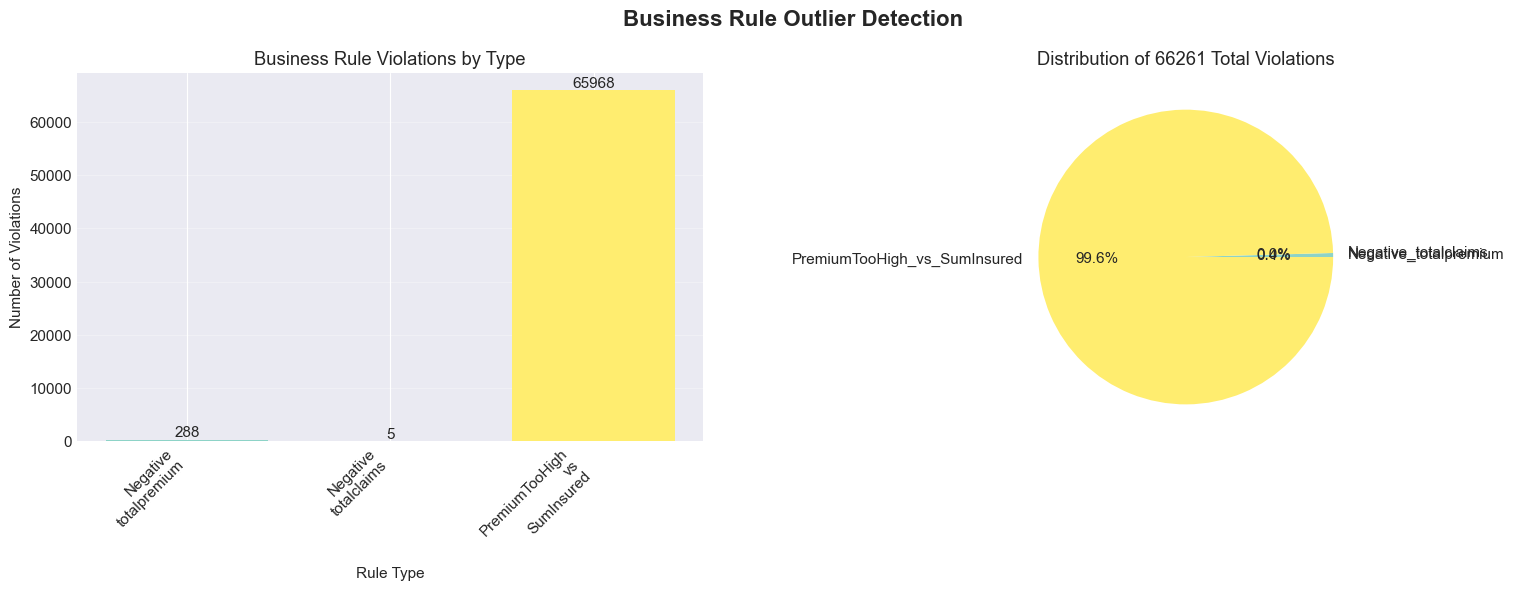


📋 BUSINESS RULE VIOLATIONS DETECTED:
    1. Negative totalpremium: 288 cases
    2. Negative totalclaims: 5 cases
    3. Premium > 50% of Sum Insured: 107595 cases
    4. Premium > 50% of Sum Insured: 65968 cases

🎯 Total rule violations: 66,261
📊 Percentage of dataset: 6.63%

📄 DETAILED VIOLATION INFORMATION:

   Negative totalpremium:
      • Count: 288
      • Min value: -782.58
      • Max value: -0.76
      • Mean value: -109.54
      • Sample indices: [82130, 118503, 121945]

   Negative totalclaims:
      • Count: 5
      • Min value: -12002.41
      • Max value: -72.00
      • Mean value: -3731.39
      • Sample indices: [183527, 230745, 605407]

   PremiumTooHigh vs SumInsured:
      • Count: 65,968
      • Sample indices: [0, 1, 12]

🔍 ADDITIONAL INSIGHTS:
   • Dataset size: 1,000,098 rows, 52 columns
   • Numeric columns: 15
   • Most common violation: PremiumTooHigh_vs_SumInsured (65,968 cases)
   • Estimated data quality: 99.9%

✅ BUSINESS RULE OUTLIER DETECTION COMPLETE


In [ ]:
# Cell 5: Business Rule Based Outlier Detection
print("="*80)
print("🎯 BUSINESS RULE BASED OUTLIER DETECTION")
print("="*80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def detect_business_rule_outliers(df):
    """
    Detect outliers based on insurance business rules
    """
    print("🔍 Detecting outliers based on insurance business rules...")
    
    business_outliers = {}
    rules = []
    
    # Find numeric columns in your actual dataset (all lowercase)
    numeric_cols = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]
    print(f"📊 Found {len(numeric_cols)} numeric columns in your data")
    
    # Rule 1: Negative values for amounts that shouldn't be negative
    # Look for columns that might be amounts (premium, claims, insured amounts)
    amount_columns = []
    for col in numeric_cols:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in ['premium', 'claim', 'amount', 'sum', 'value', 'price', 'cost']):
            amount_columns.append(col)
    
    for col in amount_columns:
        negative_values = df[df[col] < 0]
        if len(negative_values) > 0:
            business_outliers[f'Negative_{col}'] = {
                'count': len(negative_values),
                'indices': negative_values.index.tolist(),
                'values': negative_values[col].tolist(),
                'min_value': negative_values[col].min(),
                'max_value': negative_values[col].max()
            }
            rules.append(f"Negative {col}: {len(negative_values)} cases")
    
    # Rule 2: Check for zero or negative values in columns that should be positive
    positive_columns = []
    for col in numeric_cols:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in ['sum', 'value', 'insured', 'premium', 'capital']):
            positive_columns.append(col)
    
    for col in positive_columns:
        invalid_values = df[df[col] <= 0]
        if len(invalid_values) > 0 and col not in amount_columns:  # Avoid double counting
            business_outliers[f'ZeroOrNegative_{col}'] = {
                'count': len(invalid_values),
                'indices': invalid_values.index.tolist(),
                'values': invalid_values[col].tolist()
            }
            rules.append(f"Zero/Negative {col}: {len(invalid_values)} cases")
    
    # Rule 3: Check age-related columns
    age_columns = []
    for col in numeric_cols:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in ['age', 'year', 'duration', 'tenure']):
            age_columns.append(col)
    
    for col in age_columns:
        # Different age rules based on column name
        col_lower = col.lower()
        
        if 'driver' in col_lower or 'person' in col_lower:
            # Driver age: typically 18-100
            invalid_age = df[(df[col] < 18) | (df[col] > 100)]
            rule_name = 'ImpossibleDriverAge'
        elif 'vehicle' in col_lower or 'car' in col_lower:
            # Vehicle age: typically 0-50 years
            invalid_age = df[(df[col] < 0) | (df[col] > 50)]
            rule_name = 'ImpossibleVehicleAge'
        elif 'year' in col_lower:
            # Year columns: check if reasonable (e.g., 1900-2025)
            invalid_age = df[(df[col] < 1900) | (df[col] > 2025)]
            rule_name = 'InvalidYear'
        else:
            # Generic age: check for extremes
            invalid_age = df[(df[col] < 0) | (df[col] > 120)]
            rule_name = f'Extreme_{col}'
        
        if len(invalid_age) > 0:
            business_outliers[rule_name] = {
                'count': len(invalid_age),
                'indices': invalid_age.index.tolist(),
                'values': invalid_age[col].tolist(),
                'column': col
            }
            rules.append(f"{rule_name}: {len(invalid_age)} cases")
    
    # Rule 4: Check for ratio inconsistencies
    # Look for pairs of columns that might have logical relationships
    for i in range(len(numeric_cols)):
        for j in range(i+1, len(numeric_cols)):
            col1 = numeric_cols[i]
            col2 = numeric_cols[j]
            
            col1_lower = col1.lower()
            col2_lower = col2.lower()
            
            # Check if one is premium and other is sum insured
            if ('premium' in col1_lower and 'sum' in col2_lower) or \
               ('premium' in col2_lower and 'sum' in col1_lower):
                
                if 'premium' in col1_lower:
                    premium_col, sum_col = col1, col2
                else:
                    premium_col, sum_col = col2, col1
                
                # Premium shouldn't exceed sum insured by too much
                # Typically premium is 1-10% of sum insured
                ratio = df[premium_col] / df[sum_col].replace(0, np.nan)
                extreme_ratio = df[(ratio > 0.5) & (ratio.notna())]  # Premium > 50% of sum insured
                
                if len(extreme_ratio) > 0:
                    business_outliers[f'PremiumTooHigh_vs_SumInsured'] = {
                        'count': len(extreme_ratio),
                        'indices': extreme_ratio.index.tolist(),
                        'premium_values': extreme_ratio[premium_col].tolist(),
                        'sum_values': extreme_ratio[sum_col].tolist(),
                        'avg_ratio': ratio.mean()
                    }
                    rules.append(f"Premium > 50% of Sum Insured: {len(extreme_ratio)} cases")
    
    # Create visualization
    if business_outliers:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Business Rule Outlier Detection', fontsize=16, fontweight='bold')
        
        # 1. Bar chart of rule violations
        rule_names = list(business_outliers.keys())
        violation_counts = [business_outliers[rule]['count'] for rule in rule_names]
        
        bars = axes[0].bar(range(len(rule_names)), violation_counts, 
                          color=plt.cm.Set3(np.linspace(0, 1, len(rule_names))))
        axes[0].set_title('Business Rule Violations by Type')
        axes[0].set_xlabel('Rule Type')
        axes[0].set_ylabel('Number of Violations')
        axes[0].set_xticks(range(len(rule_names)))
        axes[0].set_xticklabels([r.replace('_', '\n') for r in rule_names], rotation=45, ha='right')
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, count in zip(bars, violation_counts):
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height,
                        f'{count}', ha='center', va='bottom')
        
        # 2. Pie chart of violation distribution
        total_violations = sum(violation_counts)
        if total_violations > 0:
            axes[1].pie(violation_counts, labels=rule_names, autopct='%1.1f%%',
                       colors=plt.cm.Set3(np.linspace(0, 1, len(rule_names))))
            axes[1].set_title(f'Distribution of {total_violations} Total Violations')
        else:
            axes[1].text(0.5, 0.5, 'No business rule violations detected',
                        ha='center', va='center', fontsize=12)
        
        plt.tight_layout()
        plt.show()
    else:
        print("\n📊 No business rule violations found to visualize")
    
    # Print summary
    print(f"\n📋 BUSINESS RULE VIOLATIONS DETECTED:")
    if rules:
        for i, rule in enumerate(rules, 1):
            print(f"   {i:2d}. {rule}")
        
        total_violations = sum([business_outliers[rule]['count'] for rule in business_outliers])
        print(f"\n🎯 Total rule violations: {total_violations:,}")
        print(f"📊 Percentage of dataset: {total_violations/len(df)*100:.2f}%")
        
        # Show detailed information for each violation type
        print(f"\n📄 DETAILED VIOLATION INFORMATION:")
        for rule_name, data in business_outliers.items():
            print(f"\n   {rule_name.replace('_', ' ')}:")
            print(f"      • Count: {data['count']:,}")
            
            if 'values' in data and data['values']:
                values = data['values']
                if len(values) > 0:
                    print(f"      • Min value: {min(values):.2f}")
                    print(f"      • Max value: {max(values):.2f}")
                    print(f"      • Mean value: {np.mean(values):.2f}")
            
            if 'column' in data:
                print(f"      • Column: {data['column']}")
            
            # Show sample of indices
            if 'indices' in data and data['indices']:
                sample_indices = data['indices'][:3]
                print(f"      • Sample indices: {sample_indices}")
                
    else:
        print("   ✅ No business rule violations detected")
    
    return business_outliers

# Execute business rule detection on your actual data
print(f"\n🔍 Analyzing your dataset with {len(df)} rows...")

# Show available columns for context
print(f"\n📋 First 10 columns in your data:")
for i, col in enumerate(df.columns[:10], 1):
    print(f"   {i:2d}. {col}")

# Run business rule detection
business_outliers = detect_business_rule_outliers(df)

# Show additional insights based on your specific data
print(f"\n🔍 ADDITIONAL INSIGHTS:")
print(f"   • Dataset size: {len(df):,} rows, {len(df.columns)} columns")
print(f"   • Numeric columns: {len([col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])])}")

if business_outliers:
    # Find the most common violation
    max_violation = max(business_outliers.items(), key=lambda x: x[1]['count'])
    print(f"   • Most common violation: {max_violation[0]} ({max_violation[1]['count']:,} cases)")
    
    # Calculate overall data quality score
    total_rows = len(df)
    total_violations = sum([data['count'] for data in business_outliers.values()])
    data_quality_pct = ((total_rows * len(df.columns)) - total_violations) / (total_rows * len(df.columns)) * 100
    
    print(f"   • Estimated data quality: {data_quality_pct:.1f}%")
else:
    print(f"   • No business rule violations found - data appears clean")

print("\n" + "="*80)
print("✅ BUSINESS RULE OUTLIER DETECTION COMPLETE")
print("="*80)